In [72]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
from astropy.table import Table, join
import illustris_python as il
from astropy.table import setdiff
import time as time
import scipy.signal as signal
import scipy.interpolate as interpolate
from astropy.cosmology import Planck15 as cosmo
from astropy.table import vstack
import h5py
import matplotlib.gridspec as gridspec

In [73]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

# LOADING

In [74]:
"""
300-1 Loading
"""
basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-300-1/output'

#Header gives basic group info
#snapshot_ind = 50
#header50 = il.groupcat.loadHeader(basePath, snapshot_ind)
#scale_factor50 = header50['Time']

#Header gives basic group info
snapshot_ind = 66
header66 = il.groupcat.loadHeader(basePath, snapshot_ind)
scale_factor66 = header66['Time']
fields2 = ['GroupFirstSub', 'GroupMass', 'GroupMassType','GroupNsubs','GroupPos','GroupVel',
           'Group_M_Mean200','Group_M_Crit200','Group_M_Crit500','Group_R_Crit200','Group_R_Crit500','Group_R_Mean200']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields = fields2)
halo_keys = (list(halo_grp.keys()))
halo_keys.remove('count')
#Header gives basic group info
#snapshot_ind = 99
#header99 = il.groupcat.loadHeader(basePath, snapshot_ind)
#scale_factor99 = header99['Time']


In [75]:
header = header66
scale_factor = scale_factor66

In [76]:
def cut_color_lines(table, min_gmr, max_gmr):
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    return  table[gmr_cut_low & gmr_cut_high]

def cut_mass_high(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10))
        mask = subhalomass > num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10))
        mask = subhalomass > num
        return table[mask]

def cut_mass_low(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10))
        mask = subhalomass < num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10))
        mask = subhalomass < num
        return table[mask]

In [77]:
selected_subhalos = Table.read('/home/mattbel/Desktop/Research/BhuvSummer2020/IllustrisGalaxyAnalysis/snap66/SH_star_81_GM200_14_snapshot66.fits')
addable = Table.read('/home/mattbel/Desktop/Research/BhuvSummer2020/IllustrisGalaxyAnalysis/snap66/Subhalo_stellar_8_snapshot66.fits')
addable = cut_mass_low(addable, "Group_M_Mean200", 14)


<ipython-input-76-8970e05913a2>:23: RuntimeWarning: divide by zero encountered in log10
  subhalomass = np.array(np.log10(table[field]*1e10))


In [78]:
#rho_g_list = np.load("/home/mattbel/Desktop/Research/BhuvSummer2020/IllustrisGalaxyAnalysis/snap66/rho_list_66.npy")
#rho_g_listB = np.load("/home/mattbel/Desktop/Research/BhuvSummer2020/IllustrisGalaxyAnalysis/snap66/rho_listb_66.npy")
boxsize = header['BoxSize'] #kpc/h
print(len(selected_subhalos))
Nsubs = len(selected_subhalos)
rho_g = Nsubs/(boxsize*.001)**3
print('rho_g=',rho_g)

Nsubs_b = len((selected_subhalos)[((selected_subhalos['SubhaloStellarPhotometrics'][:,4]-selected_subhalos['SubhaloStellarPhotometrics'][:,5]) < 0.5)])
rho_g_b = Nsubs_b/(boxsize*.001)**3
print('rho_g_b=',rho_g_b)
Nsubs_r = len((selected_subhalos)[(np.log10(selected_subhalos['StellarMass']*1e10)>=10.2) & ((selected_subhalos['SubhaloStellarPhotometrics'][:,4]-selected_subhalos['SubhaloStellarPhotometrics'][:,5]) > 0.55)])
rho_g_r = Nsubs_r/(boxsize*.001)**3
print('rho_g_r=',rho_g_r)
Nsubs_g = len((selected_subhalos)[(np.log10(selected_subhalos['StellarMass']*1e10)<10.2) & ((selected_subhalos['SubhaloStellarPhotometrics'][:,4]-selected_subhalos['SubhaloStellarPhotometrics'][:,5]) > 0.55)])
rho_g_g = Nsubs_g/(boxsize*.001)**3
print('rho_g_g=',rho_g_g)
rho_g_list = [rho_g,rho_g_b, rho_g_r, rho_g_g]


Nsubs_b1 = len((selected_subhalos)[((selected_subhalos['SubhaloStellarPhotometrics'][:,4]-selected_subhalos['SubhaloStellarPhotometrics'][:,5]) < 0.25)])
rho_g_b1 = Nsubs_b1/(boxsize*.001)**3
print('rho_g_b1=',rho_g_b1)
Nsubs_b2 = len((selected_subhalos)[((selected_subhalos['SubhaloStellarPhotometrics'][:,4]-selected_subhalos['SubhaloStellarPhotometrics'][:,5]) >= 0.25) & ((selected_subhalos['SubhaloStellarPhotometrics'][:,4]-selected_subhalos['SubhaloStellarPhotometrics'][:,5]) < 0.55)])
rho_g_b2 = Nsubs_b2/(boxsize*.001)**3
print('rho_g_b2=',rho_g_b2)
rho_g_listB = [rho_g, rho_g_b1, rho_g_b2]

16243
rho_g= 0.0018854050289461848
rho_g_b= 0.0003428853324821172
rho_g_r= 0.00020649729400327912
rho_g_g= 0.0012039291362574542
rho_g_b1= 9.204741660742009e-05
rho_g_b2= 0.00038293118207803135


In [79]:
centrals = selected_subhalos[selected_subhalos['IsCentral']]
centrals = centrals[centrals['GroupNsubs']>=1]
print(len(centrals))
satellites = selected_subhalos[np.bitwise_not(selected_subhalos['IsCentral'])]
print(len(satellites))
satellites_red = cut_mass_high(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, 0, 0.5)
print("Satellite galaxies red1: " + str(len(satellites_red)))
print("Satellite galaxies red2: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))
print(len(satellites_red)+len(satellites_green)+len(satellites_blue))


89
16154
Satellite galaxies red1: 1709
Satellite galaxies red2: 10372
Satellite galaxies blue: 2865
14946


In [80]:
og_sats_green = satellites_green.copy()
print(len(og_sats_green))

10372


In [81]:
'''
New Method of adding galaxies to their respective halos. 

Return to the old method of splitting into field, centrals, satellites, but only select new satellites
out of field galaxies. Then, simply add them into the list of satellite galaxies and overwrite their halo
properties with those of the new halo, then recalculate the overall halo mass, and cut more strictly on that.

Code gives nearly the same results when order through which galaxies are iterated is switched - 
this is good to see.

DEPRECATE ABOVE, IT DOESNT WORK
'''

t0 = time.time()

#iterate through all central galaxies
for i in range(0, len(centrals)):
    
    #get center of mass location for current central
    gal_cm = centrals['SubhaloPos'][i]
    
    #radius in Mpc/h to cut at
    value =  centrals['Group_R_Mean200'][i]*7*scale_factor66*0.001
    
    #Get basic info about the box bounds to prevent wrapping issues.
    boxsize = header66['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)

    #Create an array of distances from all subhalos in the data satisfying a certain criterion to gal_cm
    dev = addable['SubhaloPos'] - gal_cm
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q  
    r_subhalo = np.linalg.norm(dev, axis=1)*0.001*scale_factor66 #Mpc/h
    
    #Cut here
    to_add_now = addable[r_subhalo < value]
    #subhalo_table = subhalo_table[r_subhalo > value]
    
    if(len(to_add_now)!=0):
        og_sats_green = vstack([og_sats_green, to_add_now])
        to_add_now['IsCentral']=False
        to_add_now['SubhaloGrNr'] = np.ones(len(to_add_now))*centrals['SubhaloGrNr'][i]
        for k in range(0,len(halo_keys)):
            to_add_now[halo_keys[k]] = [centrals[halo_keys[k]][i]]*len(to_add_now)
        
        satellites = vstack([satellites, to_add_now])
    if(len(addable)==0):
        break
        
        
print(time.time()-t0)
print(len(satellites))
#from astropy.table import vstack
#all_galaxies = vstack(([satellites, centrals]))

5.618636608123779
71012


In [82]:
satellites_red = cut_mass_high(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.55, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, -0.2, 0.5)
print("Satellite galaxies red1: " + str(len(satellites_red)))
print("Satellite galaxies red2: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))
print(len(satellites_red)+len(satellites_green)+len(satellites_blue))

Satellite galaxies red1: 4477
Satellite galaxies red2: 20607
Satellite galaxies blue: 41013
66097


Number of halos with mass > 10^13 Msun:  89
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45]
[ 46  47  48  49  50  51  52  53  54  55  56  57  60  61  62  64  65  66
  67  69  70  71  72  73  74  75  76  79  80  83  85  86  87  88  91  93
  95  97  98 100 106 110 111 115 120]


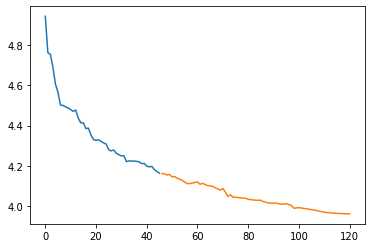

In [83]:
halo_array_masked = np.array(centrals['SubhaloGrNr'])
print("Number of halos with mass > 10^13 Msun: ", len(halo_array_masked))

centrals1 = centrals[:int(len(centrals)/2)]
centrals2 = centrals[int(len(centrals)/2):]

halo_array1 = halo_array_masked[:int(len(halo_array_masked)/2)]
halo_array2 = halo_array_masked[int(len(halo_array_masked)/2):]

plt.plot(halo_array1, np.log10(centrals1['GroupMass']))
plt.plot(halo_array2, np.log10(centrals2['GroupMass']))
print(halo_array1)
print(halo_array2)

In [84]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],})

## Helper Function

In [85]:
import astropy.stats as astats
def Bootstrap_Covariance(NDensity_list, Nb, R):
    halo_array2 = np.arange(0,len(NDensity_list))
    halo_boot = astats.bootstrap(halo_array2, bootnum=300, samples=None)
    resampled_list = []
    for b in range(0,300):
        mask_b = (np.array(halo_boot[b].astype(int)))
        resampled_profile = np.mean((np.array(NDensity_list))[mask_b], axis=0)
        resampled_list.append(resampled_profile)
    resampled_array = np.array(resampled_list)
    Yi = resampled_array
    Yi_avg = np.mean(Yi, axis=0)
    Yi_avg_array = np.tile(Yi_avg, (Nb,1))
    minus_array = Yi - Yi_avg_array
    Yi_cov = np.zeros((R,R))
    for i in range(R):
        for j in range(R):
            Yi_cov[i,j] = (1./(Nb-1.))*(np.sum(minus_array[:,i]*minus_array[:,j]))
    boot_err = np.sqrt(np.diag(Yi_cov))
    return Yi_avg, Yi_cov, boot_err

#SAVITSKY GOLAY LOG DERIVATIVE:
#Functions to get log slope\
#w = 7
#p = 5
def get_slope_sg(xx, yy, num_output, w, p):
    # Savitsky-Golay smoothing
    window_size = w
    poly_order = p
    yy_filtered = signal.savgol_filter(np.log(yy), window_size, poly_order)
    # fit spline
    yy_spline = interpolate.interp1d(np.log(xx), yy_filtered, kind = 'cubic')
    #Evaluate spline on very fine grid
    numsmooth = 1000
    lnxx_fine = np.linspace(np.log(np.min(xx)), np.log(np.max(xx)), num = numsmooth)
    lnyy_fine = yy_spline(lnxx_fine)
    yy_fine = np.exp(lnyy_fine)
    #Calculate derivative using finite differences
    dlny_dlnx_fine = (lnyy_fine[1:] - lnyy_fine[:-1])/(lnxx_fine[1:] - lnxx_fine[:-1])
    #Interpolate derivative onto desired array
    interp_func = interpolate.interp1d(lnxx_fine[:-1], dlny_dlnx_fine)
    lnxx_out = np.linspace(np.min(lnxx_fine[:-1]), np.max(lnxx_fine[:-1]), num = num_output)
    dlny_dlnx_out = interp_func(lnxx_out)
    return np.exp(lnxx_out), dlny_dlnx_out, yy_fine, np.exp(lnxx_fine)

def DensityProfileColors(RScale, Rmin,Rmax,bins,r_subhalo,blue_mask_subs,red_mask_subs,green_mask_subs):    
    # MAKING PROFILE
    bin_edge = RScale*np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1) #3.5 earlier
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]
    NDensity = []
    NDensity_blue = []
    NDensity_red = []
    NDensity_green = []
    galaxies = []
    galaxies_blue = []
    galaxies_red = []
    galaxies_green = []
    
    # LOOPING THROUGH RADII, CALCULATING NUMBER DENSITY
    for i in range(0,bins):
        mask_sep = (r_subhalo >=bin_min[i])&(r_subhalo < bin_max[i])
        r_masked = r_subhalo[mask_sep]
        number = len(r_masked)
        delta_r = bin_max[i] - bin_min[i]
        volume = (4/3)*np.pi*(((bin_max[i])**3) - ((bin_min[i])**3))
        density = number/volume
        r = (bin_min[i] + bin_max[i])/2
        galaxies.append(number)
        NDensity.append(density)
        number_blue=0
        number_red=0
        number_green=0
        if(len(blue_mask_subs) != 0):
            number_blue = len(r_subhalo[mask_sep & blue_mask_subs])
        if(len(red_mask_subs) != 0):    
            number_red = len(r_subhalo[mask_sep & red_mask_subs])
        if(len(green_mask_subs) != 0): 
            number_green = len(r_subhalo[mask_sep & green_mask_subs])

        NDensity_blue.append(number_blue/volume)
        NDensity_red.append(number_red/volume)
        NDensity_green.append(number_green/volume)        
        galaxies_blue.append(number_blue)
        galaxies_red.append(number_red)
        galaxies_green.append(number_green)
    return NDensity, NDensity_blue, NDensity_red, NDensity_green, galaxies, galaxies_blue, galaxies_red, galaxies_green

In [86]:


# PROFILE FITTING FUNCTIONS
import emcee
import scipy

r_0 = 1.5 # Fix r_0 to 1.5 Mpc/h
#rho_g= 0.027543187127290668 #(Mpc/h)^-3
#rho_g= 0.026943079757983778
#rho_g_b= 0.021698698509888134
#rho_g_r= 0.0029584016482639545
#rho_g_g= 0.0022859795998316913
# Define halo profile model

def rho_DK14(theta, r, rho_g_i):
    """
    Definition of halo profile model from Diemer Kravstov 2014
    r_s, r_t, r must all be in units of kpc/h
    """
    
    lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
    alpha = 10.**lg_alpha
    beta = 10.**lg_beta
    gamma = 10.**lg_gamma
    r_s = 10.**lg_r_s
    r_t = 10.**lg_r_t
    rho_s = 10**lg_rho_s
    rho_0 = 10**lg_rho_0
    
   
    def rho_inner(r):
        exp_arg = -2/alpha*(((r/r_s)**alpha)-1)
        return rho_s*np.exp(exp_arg)

    def rho_outer(r):
        return rho_0*((r/r_0)**(-s_e)) + rho_g_i

    def f_trans(r):
        return (1+(r/r_t)**beta)**(-gamma/beta)
    
    return rho_inner(r)*f_trans(r)+rho_outer(r)

    
def ln_like3d(theta,  r_data, rho_data, cov, rho_g_i,blue):
    """
    Definition of log-likelihood using DK14 model
    """
    
    rho_thr = rho_DK14(theta, r_data, rho_g_i)
    diff = rho_data-rho_thr
    
    likelihood = -1/2 * np.dot(diff, np.linalg.solve(cov, diff))
    
    if (np.isnan(likelihood)==True):
        return -np.inf

    return likelihood


def ln_prior(theta,blue):
    """
    Definition of parameter priors
    """

    lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
    alpha = 10.**lg_alpha
    beta = 10.**lg_beta
    gamma = 10.**lg_gamma
    r_s = 10.**lg_r_s
    r_t = 10.**lg_r_t
    rho_s = 10**lg_rho_s
    rho_0 = 10**lg_rho_0
    
    
    # Top hat prior on r_s, r_t, s_e
    if blue==True:
        r_s_check = (r_s > 1) & (r_s < 10000) #FOR BLUES PROFILES
        #print('BLUE PRIOR PASSED')
    else:
        r_s_check = (r_s > 0.01) & (r_s < 5)#(r_s > 0.1) & (r_s < 5000) #Blues #most stuff before Blues run with .01

    r_t_check = (r_t > 0.1) & (r_t < 5)
    #s_e_check = (s_e > .1) & (s_e < 10)
    s_e_check = (s_e > .3) & (s_e < 5)

    rho_s_check =(rho_s >= 0.00000001) & (rho_s < 50000000)
    #rho_s_check = True
    #rho_0_check = True
    rho_0_check = (rho_0 >= 0.00000001) & (rho_0 < 50000000)

    flat_prior_check = r_s_check & r_t_check & s_e_check & rho_s_check & rho_0_check 
    
    if not flat_prior_check:
        return -np.inf

    return  -0.5*(lg_alpha - np.log10(0.19))**2/0.2**2 - 0.5*(lg_beta - np.log10(6.0))**2/0.6**2 - 0.5*(lg_gamma - np.log10(4.0))**2/0.6**2
    

def ln_prob3d(theta, r, rho, cov, rho_g_i,blue):
    """
    Total probability definition (likelihood+prior)
    """
    lp = ln_prior(theta,blue)
    
    if not np.isfinite(lp):
        return -np.inf

    return lp+ln_like3d(theta, r, rho, cov, rho_g_i,blue)


def main(p0,n_walkers,n_iter,n_dim,n_burn,ln_prob, data):
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_prob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, n_burn, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, n_iter, progress=True)

    return sampler, pos, prob, state

def MCMC(averaged_r_tot, profiles, covs,rho_g_list,blue_list,init_theta_list, bounds, n_burn, n_walkers, n_iter):
    labels = [r'$\log(\alpha)$', r'$\log(\beta)$', r'$\log(\gamma)$', r'$\log(r_s)$', r'$\log(r_t)$', r'$\log(\rho_s)$', r'$\log(\rho_0)$', r'$s_e$']
    best_fit_mcmc_list = []#[best_fit_mcmc, best_fit_mcmc_blue, best_fit_mcmc_red, best_fit_mcmc_green]
    samples_list = []
    sampler_list = []
    #rho_g_list = [0.026943079757983778, 0.021698698509888134, 0.0029584016482639545, 0.0022859795998316913]
    for i in range(len(profiles)):#(1,2):#
        averaged_r_tot = averaged_r_tot #in Mpc/h
        averaged_rho_tot = profiles[i] #- rho_g_list[i]#Yi_avg1
        rho_g_i = rho_g_list[i]
        cov = covs[i]
        init_theta = init_theta_list[i]
        if blue_list[i] == True:
            blue = True
        else:
            blue = False
        # Fit TNG_300-1 Profiles
        data = [averaged_r_tot, averaged_rho_tot, cov,rho_g_i,blue]
        args = (averaged_r_tot, averaged_rho_tot, cov,rho_g_i,blue)
        # Set initial guess and boundaries and use minimization to determine start position of MCMC chain
        #lg_alpha, lg_beta, lg_gamma, lg_r_s, lg_r_t, lg_rho_s, lg_rho_0, s_e = theta
        #init_theta = np.array([-0.50257944, 0.58536, 0.90564052,  -0.5, 0.35784823, 13.8549328, 8.051313892 , 1.30773031])
        #init_theta = np.array([-.92, 0.78, 0.60, -0.61, 0.34, 2.7, -.3 , 1.66])
        ndim = 8 #number of free parameters
        neg_ll3d = lambda *args: -ln_like3d(*args)

        res = scipy.optimize.minimize(neg_ll3d, init_theta, args=args, method='SLSQP', options = {'maxiter':500}, bounds=bounds)

        # Run MCMC
        n_burn = n_burn#10000#500?? or 1000
        n_dim, n_walkers = 8, n_walkers#128#128 #increasing walkers from 500 to 1000 seemed to help, maybe return n_iter and n_burn to lower values
        n_iter = n_iter#5000
        # WORKED with 5000,8,200,10000. pretty good with 1000 for burn. 
        # BEST is 10000,8,128,5000 takes 280 seconds for main part 
        p0 = [res.x + 1e-3*np.random.randn(n_dim) for i in range(n_walkers)]
        sampler, pos, prob, state = main(p0, n_walkers, n_iter, n_dim, n_burn,ln_prob3d, data)
        samples = sampler.flatchain
        corner.corner(samples, labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True);
        samples_list.append(samples)
        best_fit_mcmc_list.append(samples[np.argmax(sampler.flatlnprobability)])
        sampler_list.append(sampler)

    print('done MCMC')
    return best_fit_mcmc_list, samples_list, sampler_list

def FittedPlots(best_fit_mcmc_list_DF, profiles, averaged_r_tot,Ravg,covs,rho_g_list,sigs,labels, colors, ls_list):
    '''
    fig, ax = plt.subplots(3,1,figsize=(10,17))
    ax0 = ax[0]
    ax1 = ax[1]
    ax2 = ax[2]
    '''
    plt.figure(figsize=(9,11))#(10,13))#(10,13)#(20,28))
    #ax0 = plt.subplot(3,1,1)
    #ax1 = plt.subplot(3,1,2)
    #ax2 = plt.subplot(3,1,3)
    #ax0 = plt.subplot(3,1,1)
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    
    #ax3 = ax2.twiny()
    plt.tight_layout()
    halo_masses = []
    for h_i in halo_array_masked:
        halo_masses.append(halo_grp['GroupMass'][h_i]*1e10)
    r_sp_list = []
    r_sp_r200_list = []
    bins = 20
    for i in range(len(colors)):#(1,2):#
        best_fit_mcmc = best_fit_mcmc_list_DF[i]
        averaged_rho_tot = profiles[i]
        r_thr = np.logspace(np.log10(np.min(averaged_r_tot)), np.log10(np.max(averaged_r_tot)), 3000)

        log_deriv_mcmc = r_thr/rho_DK14(best_fit_mcmc,r_thr, rho_g_list[i])*np.gradient(rho_DK14(best_fit_mcmc,r_thr, rho_g_list[i]), r_thr)

        r_sp = r_thr[np.argmin(log_deriv_mcmc)]
        r_sp_r200 = r_sp/Ravg
        r_sp_list.append(r_sp)
        r_sp_r200_list.append(r_sp_r200)
        #plt.subplot(3,1,1)
        '''
        bins0 = np.logspace(np.min(np.log10(halo_masses)), 
                           np.max(np.log10(halo_masses)), 30)

        ax0.hist(halo_masses, bins=bins0, color = 'cadetblue')
        title_str = r"Mass Distribution of %s Clusters ($\overline{m}$= " % (Number_of_halos)
        title_str += ("{:.3E} $M\odot$)").format(np.mean(halo_masses))
        ax0.set_title(title_str+' (Minimum = 5*10$^{13}$)', fontweight="bold")
        ax0.set_xlabel(r"Cluster Mass ($M_{\odot}$)")
        ax0.set_ylabel("Count")
        ax0.set_xscale("log")
        ax0.set_yscale("log")

        '''
        Min = min(averaged_r_tot)/Ravg
        Max = max(averaged_r_tot)/Ravg
        ax1.plot(r_thr/Ravg, rho_DK14(best_fit_mcmc, r_thr, rho_g_list[i]), color=colors[i], linestyle=ls_list[i] 
                 , label="Model Fit %s" %(labels[i]))
        ax1.errorbar(averaged_r_tot/Ravg, averaged_rho_tot, 
                     yerr=np.sqrt(np.diag(covs[i])), 
                     marker = '.', color = colors[i], linestyle = "none",
                     markersize = 5, ecolor = colors[i], elinewidth = 1, capsize=2, 
                     markeredgewidth=1, label="Data %s" %(labels[i]))
        #plt.errorbar(bin_stack1, Yi_avg1, yerr = boot_err1, c = 'slategray', ecolor = 'lightslategrey', elinewidth = 3, capsize=3, label = 'All galaxies')
        ax1.axvline(r_sp_r200, linestyle=ls_list[i], color=colors[i])
        ax1.legend(frameon=False, loc="upper right")
        #ax1.set_title("300-1 Galaxy Number Density Profiles (Subhalos > 10$^{%s}$, Bins = %s)" %(M,bins), fontweight="bold")
        ax1.set_xlabel('r/$R200_{m}$', fontsize=15)#(r"$r$ [h$^{-1}$Mpc]")
        ax1.set_ylabel('$\Sigma_g$', fontsize=15)#(r"$\rho$ [$M_{\odot}h^3$Mpc$^{-3}$]", fontsize=15)
        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_xlim(Min,Max)#(0.08, 3) #2


        #plt.subplot(3,1,3)
        ax2.plot(r_thr/Ravg, log_deriv_mcmc, label='Rsp = %s , %s (Mpc/h)' %("{:.5f}".format(r_sp_r200),"{:.5f}".format(r_sp)), color=colors[i], linestyle=ls_list[i])
        ax2.axvline(r_sp_r200, linestyle=ls_list[i], color=colors[i])
        ax2.errorbar(r_sp_r200,np.min(log_deriv_mcmc),xerr = sigs[i],color = colors[i], fmt = 'o', elinewidth = 4,capsize = 5, alpha = .5)
        ax2.set_xscale("log")
        #ax2.set_title("Log Derivatives of Model Fits", fontweight="bold", color="k")
        ax2.set_xlabel('r/$R200_{m}$', fontsize=15)#(r"$r$ [h$^{-1}$Mpc]")
        ax2.set_ylabel(r"$d\log \rho / d \log r$", fontsize=15)
        ax2.set_xlim(Min,Max)#(0.08, 3) #2
        ax2.set_ylim(-5.5, -0.5)
        ax2.legend(frameon=False, loc="lower right")
        
        '''
        ax3 = ax2.twiny()
        #ax3.set_xticks(np.array([.1,1,2])*Ravg)#(ax2.get_xticks()))#
        newlabel = [.1,.5,1.,2.]
        func = lambda x: np.log10(x*Ravg)
        newpos = [func(x) for x in newlabel]
        ax3.set_xticks(newpos)
        ax3.set_xticklabels(newlabel)
        #ax3.set_xticks([.2,2,4])#(ax2.get_xticks()))#

        #ax3.set_xticklabels(np.array([.1,1,2]))
        #ax3.set_xticklabels(float(ax1.get_xticklabels())/Ravg)
        #ax3.set_xscale(ax2.get_xscale())
        ax3.set_xlim(ax2.get_xlim())
        #secax = ax.secondary_xaxis('top')
        '''
    plt.tight_layout()
    plt.show()
    print("R_avg=",Ravg)
    return r_sp_list, r_sp_r200_list

import sys
def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
def get_rsp(r_thr,model_params,rho_g_list):
    log_deriv_mcmc = r_thr/rho_DK14(model_params,r_thr, rho_g_list[0])*np.gradient(rho_DK14(model_params,r_thr, rho_g_list[0]), r_thr)
    return r_thr[np.argmin(log_deriv_mcmc)]

## Profile Code

In [87]:
def DensityProfileMulti(RScale,Rmin,Rmax,bins,r_subhalo,mask_list):    
    # MAKING PROFILE
    bin_edge = RScale*np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1) #3.5 earlier
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]

    ND = np.zeros((len(mask_list), bins))
    
    GALAXIES = np.zeros((len(mask_list), bins))
    
    
    # LOOPING THROUGH RADII, CALCULATING NUMBER DENSITY
    for i in range(0,bins):
        mask_sep = (r_subhalo >=bin_min[i])&(r_subhalo < bin_max[i])
        delta_r = bin_max[i] - bin_min[i]
        volume = (4/3)*np.pi*(((bin_max[i])**3) - ((bin_min[i])**3))
        
        for j in range(0,len(mask_list)):
            mask = mask_list[j]
            number_j = len(r_subhalo[mask_sep & mask])
            density_j = number_j/volume
            ND[j,i] = (density_j)
            GALAXIES[j,i] = (number_j)
            
    return ND, GALAXIES

def MultiProfiles(cut, N, M, sat_sh, cen_sh, color_cut, red_mass_cut, toprint):
    w = 9
    p=5
    bins = 20#30#15
    Rmin = .1
    Rmax = 7#5.5 # for R200c#7
    Halo_Rmax = 7
    redshift = header['Redshift']
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    
    ND_LIST = []
    ND_BOOT = []
    RScale_list = []
   
    for i in range(0,len(cen_sh)):
        
        subhalo_table_hi = sat_sh[sat_sh['SubhaloGrNr'] == cen_sh['SubhaloGrNr'][i]]
        
        if(toprint):
            print("\nHalo:", h_i1)
            print("Halo Mass:", halo_grp['GroupMass'][h_i1])
            #N_subhalos = halo_grp['GroupNsubs'][h_i1]
            #print("N Subhalos from Illustris Algorithm:",N_subhalos, time.time()-t0)
            # TAKING TABLE WITH CLEAN SUBS AFTER MASS CUT AND GETTING FOR DISTANCE
            R500c = 0.001*scale_factor*cen_sh['Group_R_Crit500'][i] #ckpc/h to Mpc/h
            R200c = 0.001*scale_factor*cen_sh['Group_R_Crit200'][i]
            R200m = 0.001*scale_factor*cen_sh['Group_R_Mean200'][i]
            #M200m = halo_grp['Group_M_Mean200'][h_i]
            print("R500c, R200c, R200m:",R500c, R200c, R200m)
        Number_of_halos = len(cen_sh)
        RScale = 0.001*scale_factor*cen_sh['Group_R_Mean200'][i]
        RScale_list.append(RScale)
        dev = np.array(subhalo_table_hi['SubhaloPos']-cen_sh['GroupPos'][i]) 
        
        for ind, q in enumerate(dev.T):
            q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
            dev.T[ind] = q
        r_subhalo_all = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h #has all subhalos > mass cut
        r_subhalo_hi = r_subhalo_all[r_subhalo_all<=(Halo_Rmax*RScale)]
        
        #CUTS
        if cut == 'color':
            mag = subhalo_table_hi['SubhaloStellarPhotometrics']
            gmr = mag[:,4]-mag[:,5]
            #rmz = mag[:,5]-mag[:,7]
            b1 = -.2#.2
            b2 = 0.50#.59#.734
            r1 = 0.50#.6#.735
            r2 = 1.#1.
            sm = np.log10(subhalo_table_hi['StellarMass']*1e10)

            if color_cut == 'basic':
                blue_mask_subs = (gmr<0.50)#(gmr<0.53)

                if red_mass_cut == 'stellarmass':
                    sm = np.log10(subhalo_table_hi['StellarMass']*1e10)
                    sm1 = 10.2
                    red_mask_subs = (gmr>r1)&(sm>=sm1)#&(gmr>((slope*sm)+intercept))#(gmr>=0.6)#(gmr>0.59)#
                    green_mask_subs = (gmr>r1)&(sm<sm1)#&(gmr<((slope*sm)+intercept))
                    color_title = 'Stellar Mass Basic [%s,%s]' %(r1,sm1)#'[%s,%s,%s,%s,%s]' %(b2,r1,sm1,slope,intercept)
                elif red_mass_cut == 'subhalomass':
                    subm = np.log10(subhalo_table_hi['SubhaloMass']*1e10)
                    subm1 = 11.1
                    red_mask_subs = (gmr>r1)&(subm>=subm1)#&(gmr>((slope*sm)+intercept))#(gmr>=0.6)#(gmr>0.59)#
                    green_mask_subs = (gmr>r1)&(subm<subm1)#&(gmr<((slope*sm)+intercept))
                    color_title = 'Subhalomass Basic [%s,%s]' %(r1,subm1)#'[%s,%s,%s,%s,%s]' %(b2,r1,sm1,slope,intercept)
            elif color_cut == 'refined':
                sm = np.log10(subhalo_table_hi['StellarMass']*1e10)
                sm1 = 10.2
                slope = -0.4
                intercept = 4.8
                blue_mask_subs = (gmr<b2)&(gmr<((slope*sm)+intercept))#(gmr<0.6)#(gmr<0.53)#
                red_mask_subs = (gmr>r1)&(sm>=sm1)&(gmr>((slope*sm)+intercept))#(gmr>=0.6)#(gmr>0.59)#
                green_mask_subs = (gmr>r1)&(sm<sm1)&(gmr<((slope*sm)+intercept))
                color_title = 'Stellar Mass Refined [%s,%s,%s,%s,%s]' %(b2,r1,sm1,slope,intercept)
            title = color_title
            mask_list = [(gmr>-100),blue_mask_subs,red_mask_subs,green_mask_subs]
            plot_color_list = ['slategrey', 'steelblue','firebrick','#fa5f1b']
            label_list = ['All', 'Blue', 'Red1 (High Mass)', 'Red2 (Low Mass)']
        elif cut == 'blues':
            mag = subhalo_table_hi['SubhaloStellarPhotometrics']
            gmr = mag[:,4]-mag[:,5]
            #rmz = mag[:,5]-mag[:,7]
            r1 = .50
            blue_mask_subs = (gmr<r1)#(gmr<0.53)
            blue_mask_subs2 = (gmr<r1)&(gmr>=0.25)#(gmr<0.53)
            blue_mask_subs1 = (gmr<0.25)&(gmr>-.2)#(gmr<0.53)
            mask_list = [(gmr>-100),blue_mask_subs, blue_mask_subs1, blue_mask_subs2]
            plot_color_list = ['slategrey', 'steelblue','blue','teal' ]
            label_list = ['All', 'Blue', 'Blue1 (More Blue)', 'Blue2 (Less Blue)']
            title = 'Blues'
        elif cut == 'sm':
            #sm = np.log10(subhalo_table_hi['StellarMass']*1e10)
            #sm = np.log10(subhalo_table_hi['SubhaloMass']*1e10)
            sm = (subhalo_table_hi['SubhaloVmax']) #km/s
            v2 = np.median(sm)
            
            v1 = np.median(sm[sm<v2])
            v3 = np.median(sm[sm>v2])
            massmask1 = (sm<v1)
            massmask2 = (sm<v2)#(sm>=v1)&
            massmask3 = (sm<v3)#(sm>=v2)&
            massmask4 = (sm<=np.max(sm))#(sm>=v3)
            #massmask1 = (sm>=(8))&(sm<(9))
            #massmask2 = (sm>=(9))&(sm<(10))
            #massmask3 = (sm>=(10))&(sm<(11))
            #massmask4 = (sm>=(11))&(sm<(12))
            #massmask1 = (sm>=(9))&(sm<(10))
            #massmask2 = (sm>=(10))&(sm<(11))
            #massmask3 = (sm>=(11))&(sm<(12))
            #massmask4 = (sm>=(12))#&(sm<(13))
            mask_list = [massmask1, massmask2, massmask3, massmask4]
            plot_color_list = ['lightpink', 'palevioletred','darkmagenta','rebeccapurple' ]
            label_list = ['<v1', '<v2', '<v3', 'all'] #vcmax
            #label_list = ['10^8-10^9', '10^9-10^10', '10^10-10^11', '10^11-10^12'] #original
            #label_list = ['10^9-10^10', '10^10-10^11', '10^11-10^12', '>10^12] #subhalomass
            #label_list = ['10^8-10^9', '10^9-10^10', '10^10-10^11', '>10^11'] # >11

            #title = 'Stellar Mass Split Galaxies'
            #title = 'Subhalomass Split Galaxies'
            title = 'Vcmax Split Galaxies'

        elif cut == 'subs':
            subm0 = np.log10(subhalo_table_m['SubhaloMass']*1e10)
            mean = np.mean(subm0)#11.1
            subm = np.log10(subhalo_table_hi['SubhaloMass']*1e10)

            if(toprint):
                print('mean subm0=',mean)
            submask1 = (subm <= mean)
            submask2 = (subm > mean)
            mask_list = [submask1, submask2]
            plot_color_list = ['greenyellow', 'forestgreen']
            label_list = ['lower mass subhalos', 'higher mass subhalos']
            title = 'Subhalos in 2 subhalomass bins'
        elif cut == 'subs3':
            #subm0 = np.log10(subhalo_table_m['SubhaloMass']*1e10)
            #mean = np.mean(subm0)#11.1
            subm = np.log10(subhalo_table_hi['SubhaloMass']*1e10)

            #print('mean subm0=',mean)
            submask1 = (subm >= 10)
            submask2 = (subm >= 11)
            submask3 = (subm >= 12)
            
            mask_list = [submask1, submask2, submask3]
            plot_color_list = ['greenyellow', 'forestgreen', 'darkolivegreen']
            label_list = ['>10', '>11','>12']
            title = 'Subhalos in 3 cumulative bins'
        elif cut == 'subs2':
            subm = np.log10(subhalo_table_m['SubhaloMass']*1e10)
            mag = subhalo_table_hi['SubhaloStellarPhotometrics']
            gmr = mag[:,4]-mag[:,5]
            r1 = 0.50#.6#.735
            r2 = 1.#1.
            notred_mask_subs = ~((gmr>r1)&(gmr<1.5))#&(gmr>((slope*sm)+intercept))#(gmr>=0.6)#(gmr>0.59)#
            mean = np.mean(subm)
            submask1 = (subm <= mean)&(notred_mask_subs)
            submask2 = (subm > mean)&(notred_mask_subs)
            mask_list = [submask1, submask2]
            plot_color_list = ['mediumaquamarine', 'teal']
            label_list = ['lower mass subhalos', 'higher mass subhalos']
            title = 'Subhalos in 2 subhalomass bins (WITHOUT REDS)'
        elif cut == 'all-red1':
            mag = subhalo_table_hi['SubhaloStellarPhotometrics']
            gmr = mag[:,4]-mag[:,5]
            r1 = 0.50#.6#.735
            r2 = 1.#1.
            sm = np.log10(subhalo_table_hi['StellarMass']*1e10)
            sm1 = 10.2
            notred_mask_subs = ~((gmr>r1)&(sm>=sm1))#&(gmr>((slope*sm)+intercept))#(gmr>=0.6)#(gmr>0.59)#
            mask_list = [(gmr>-100), notred_mask_subs]
            plot_color_list = ['dimgrey', 'silver']
            label_list = ['All', 'All w/o Red1']
            title = 'All galaxies except Red1'
        ND, GAL = DensityProfileMulti(RScale, Rmin,Rmax,bins,r_subhalo_hi,mask_list)    
        if(toprint):
            for k in range(0,N):
                print("galaxies", k, GAL[k])
    

        #print("sum of galaxies:", sum(galaxies))
        ND_LIST.append(ND)
        
    # RADIAL BINS, R_AVG, ETC
    R_avg = np.mean(RScale_list) #Mpc/h
    print("R_avg:", R_avg)
    bin_divided = np.logspace(np.log10(Rmin), np.log10(Rmax), num=bins+1)
    bin_stack = R_avg*(bin_divided[1:]+bin_divided[:-1])/2

    Yi_avg_list = []
    cov_list = []
    boot_err_list = []
    plt.figure(figsize=(10,10))
    #plt.figure(figsize=(10,13))#(10,13)#(20,28))
    ax0 = plt.subplot(2,1,1)
    ax1 = plt.subplot(2,1,2)
    plt.tight_layout()
    for i in range(0,N):
        Yi_avg, cov, boot_err = Bootstrap_Covariance(np.array(ND_LIST)[:,i,:], 300, bins)
        Yi_avg_list.append(Yi_avg)
        cov_list.append(cov)
        boot_err_list.append(boot_err)
        dlog_data_SG_x1, dlog_data_SG_y1, yy_fine1, xx_fine1 = get_slope_sg(bin_stack, (Yi_avg), 1000,w,p)  
        ax0.errorbar(bin_stack, Yi_avg, yerr = boot_err, c = plot_color_list[i], ecolor = plot_color_list[i], elinewidth = 3, capsize=3, label = label_list[i])
        ax0.set_xscale('log')
        ax0.set_yscale('log')
        ax0.set_xlabel('R (Mpc/h)')
        ax0.set_ylabel('Galaxy Number Density')# (scaled by M200m)
        ax0.set_title('300-1 Stacked Profile of %s Clusters (ALL SUBHALOS IN DIST)\n (%s Bins)(Stellar Mass > 10^%s, Color: %s)' %(Number_of_halos, bins, M, title), fontweight = 'bold', wrap=True)
        ax0.legend()
        ax1.plot(dlog_data_SG_x1, dlog_data_SG_y1, c = plot_color_list[i])
        ax1.set_xscale('log')
        ax1.set_xlabel('R (Mpc/h)')
        ax1.set_ylabel('dlog of Number Density')
    plt.show()
    
    return bin_stack, Yi_avg_list, cov_list, boot_err_list, R_avg, title

## RUN PROFILE

R_avg: 0.8701007239330811


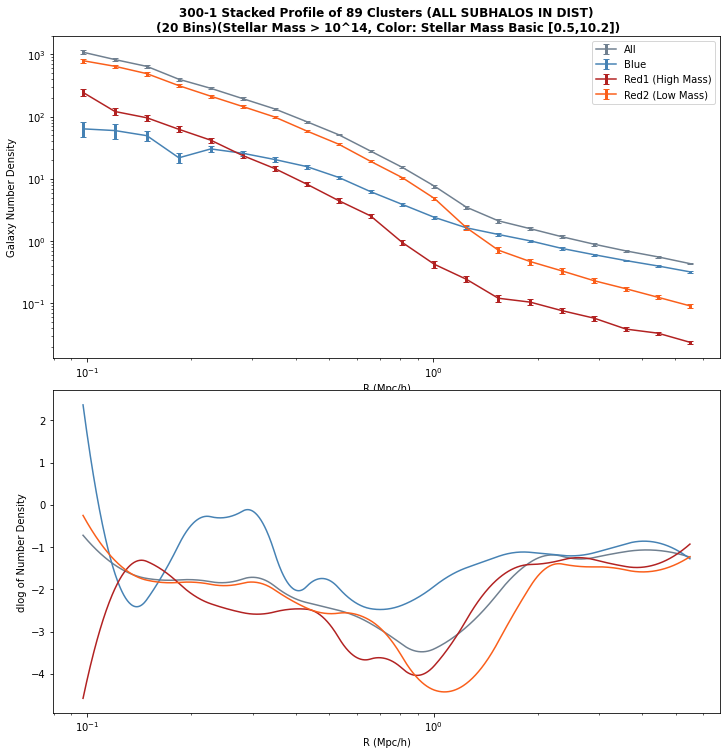

In [88]:
bin_stack2, Yi_avg_list2, cov_list2, boot_err_list2, R_avg2, title2 = MultiProfiles('color',4, 14, satellites, centrals, 'basic','stellarmass', False)


<ipython-input-86-d07bd75b2ffe>:30: RuntimeWarning: overflow encountered in power
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)
<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
/home/mattbel/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Running burn-in...


Running production...


/home/mattbel/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Running burn-in...


Running production...


Running burn-in...


<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
<ipython-input-86-d07bd75b2ffe>:30: RuntimeWarning: overflow encountered in power
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)


Running production...


<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)
<ipython-input-86-d07bd75b2ffe>:30: RuntimeWarning: overflow encountered in power
  exp_arg = -2/alpha*(((r/r_s)**alpha)-1)


Running burn-in...


Running production...
done MCMC
696.6847348213196


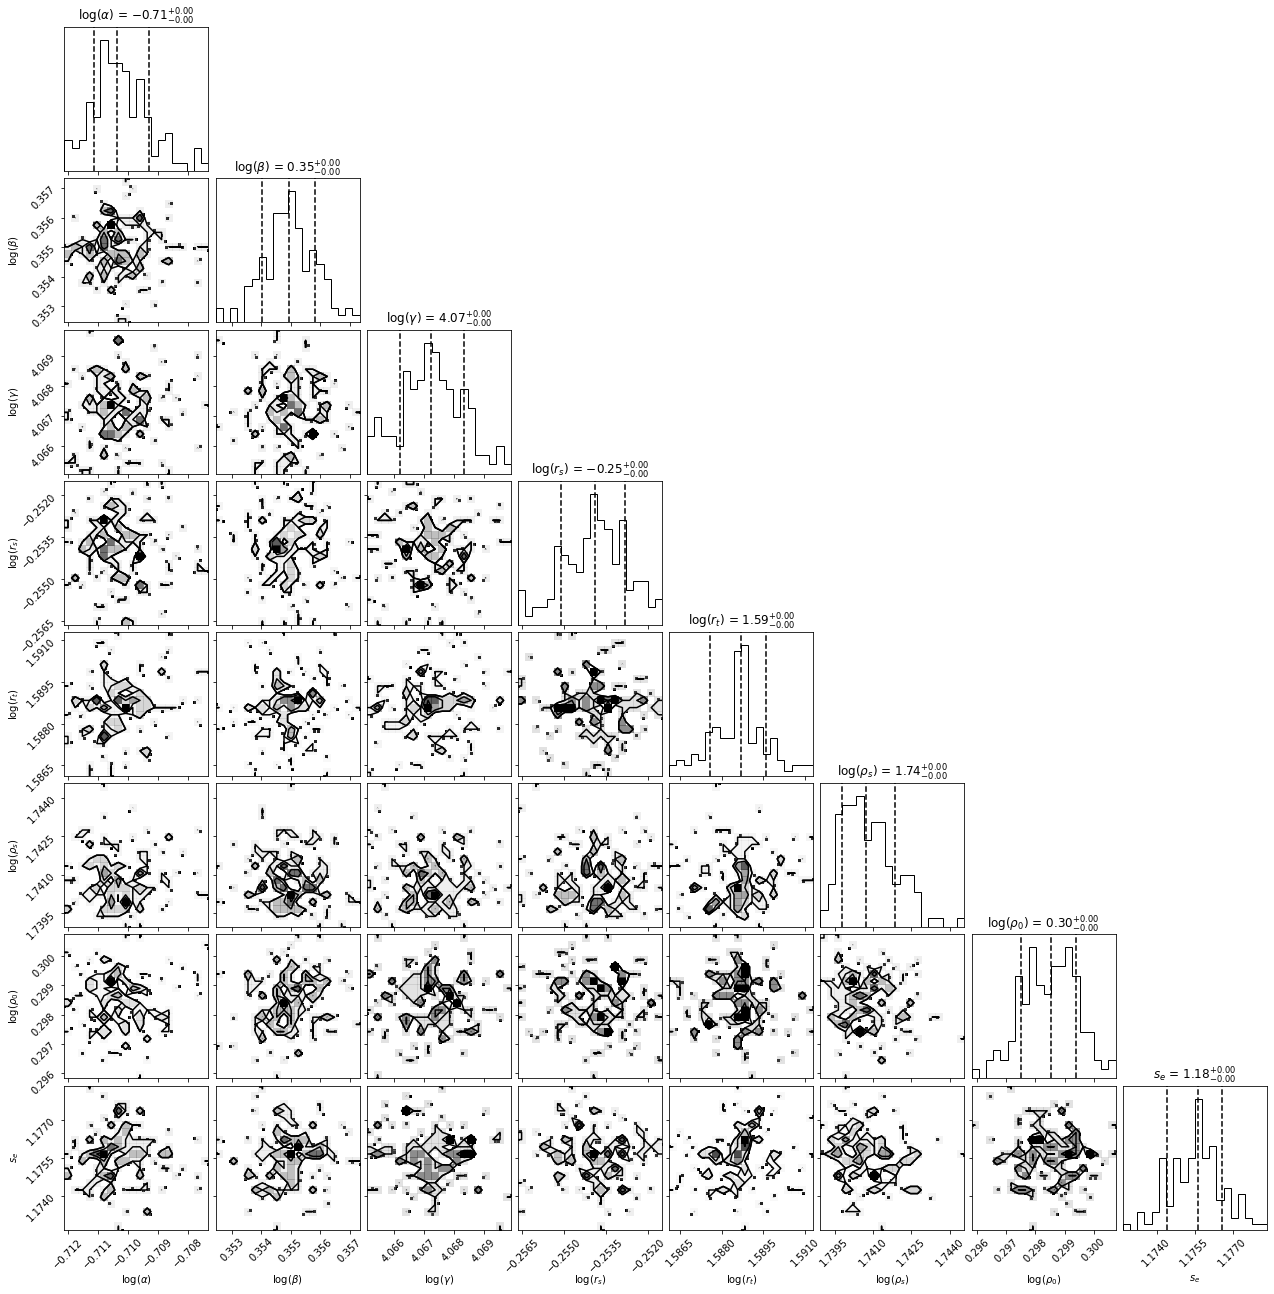

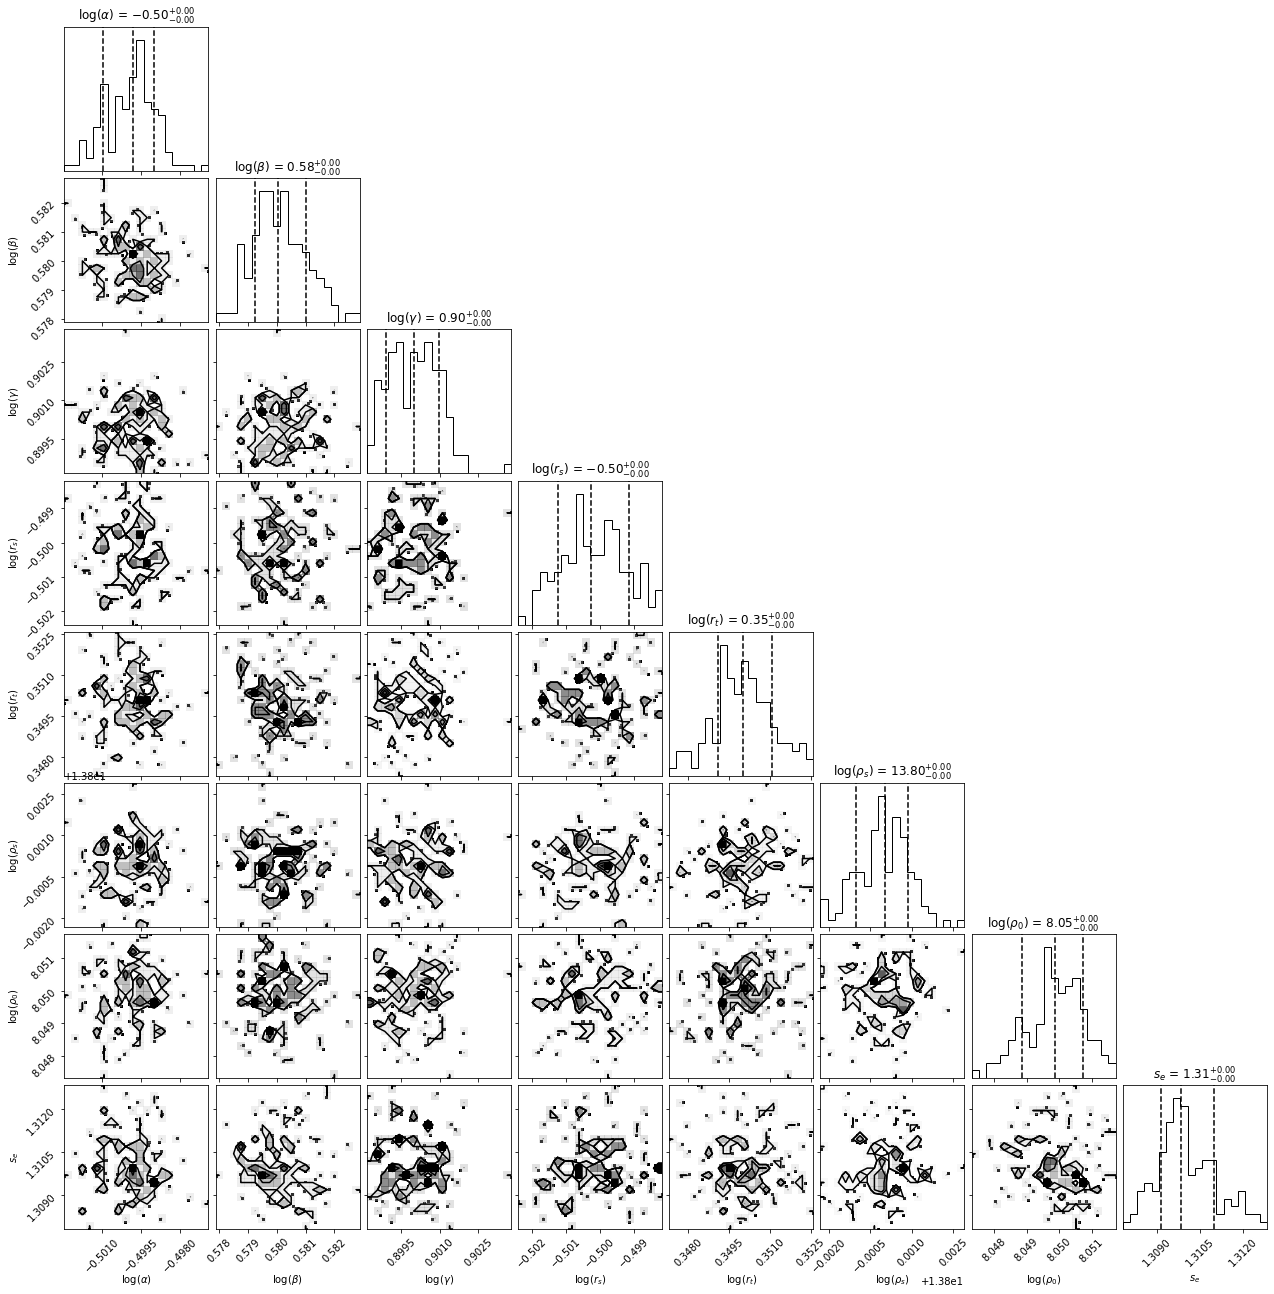

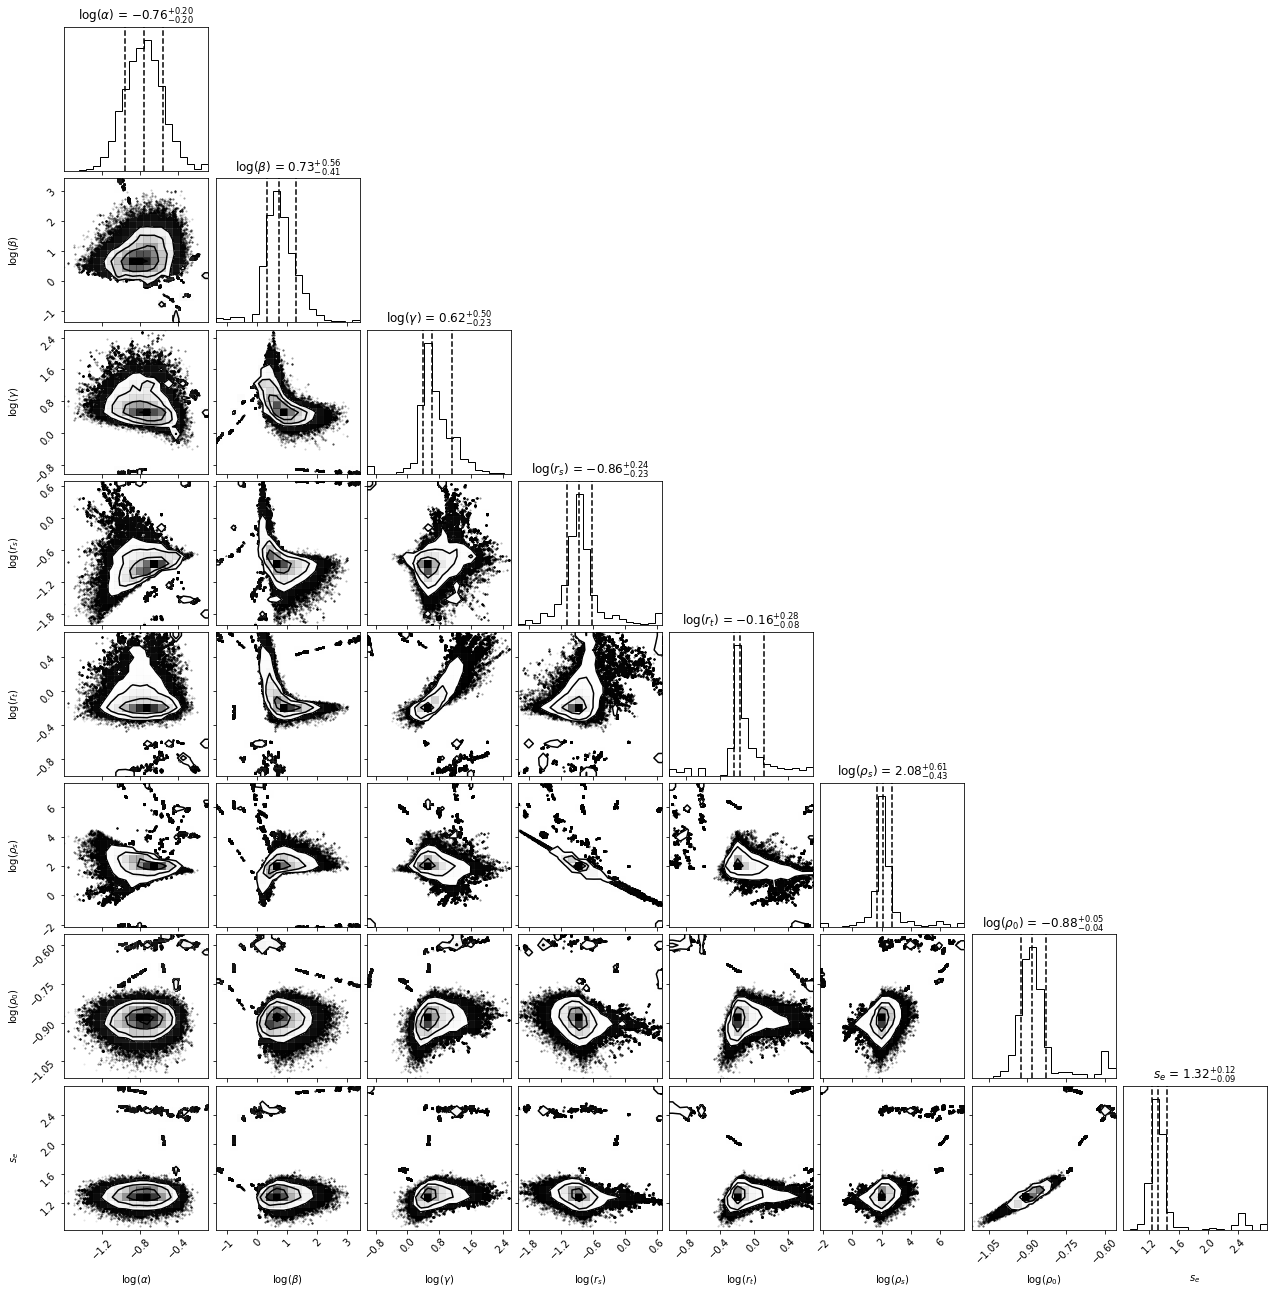

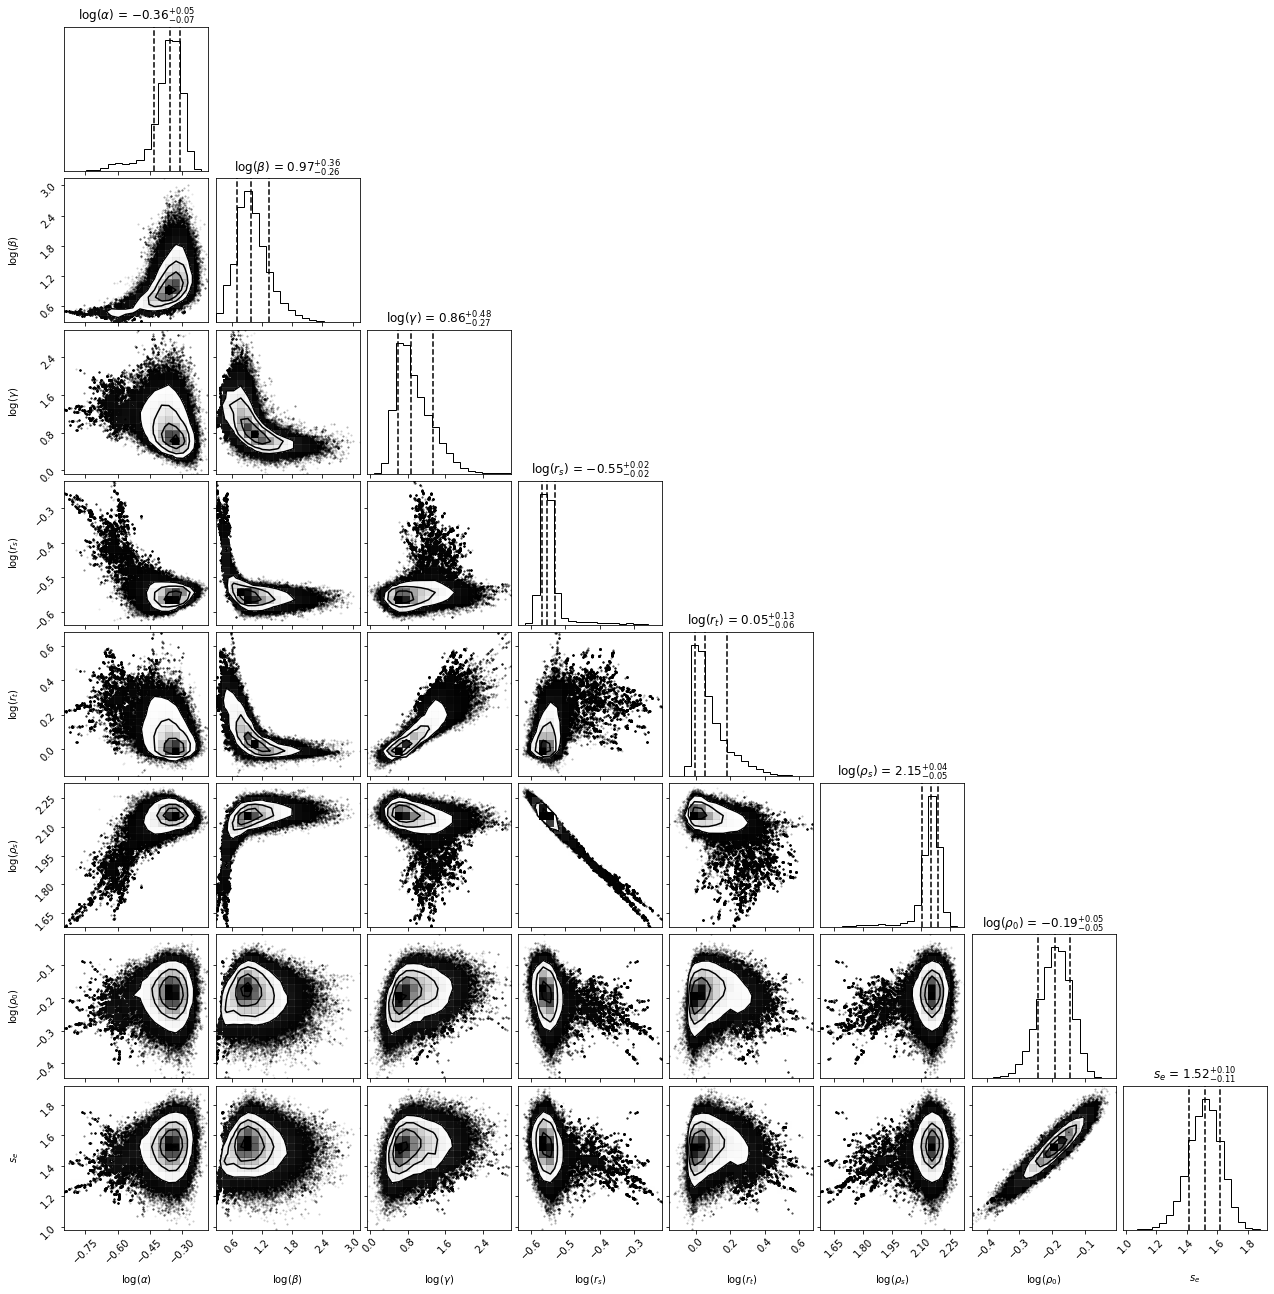

In [93]:
import corner
#MCMC
t0 = time.time()


profiles = Yi_avg_list2#[Yi_avg_list2[2],Yi_avg_list2[3]]#
covs = cov_list2

init_theta_list1 = np.array([[-.92, 0.78, 0.60, -0.2, 0.02, 1.5, .2 , 1.66],[-0.50, 0.58, 0.90,  0.5, 0.35, 13.8, 8.05 , 1.31],[-.92, 0.78, 0.60, -.61, 0.34, 2, 3 , 1.66],[-.92, 0.78, 0.60, -1, -.34, 3, -0.5 , 1.66]]) # ps was 2, r_s was -0.61, p0 was 3, r_t was .34
#init_theta_list1 = np.array([[-.92, 0.78, 0.60, -.61, 0.34, 2, 3 , 1.66],[-.92, 0.78, 0.60, -1, -.34, 3, -0.5 , 1.66]]) # ps was 2, r_s was -0.61, p0 was 3, r_t was .34

bounds = ((-19, 10),(-14, 30), (-12,30), (-20, 7), (-20, 7), (-10, 50), (-10, 50), (.1, 30))
#rho_g_list = [0.0029584016482639545, 0.0022859795998316913]
#rho_g_list = [0.026943079757983778, 0.021698698509888134, 0.0029584016482639545, 0.0022859795998316913]

blue_list1 = [False, True, False, False]
#blue_list1 = [False, False]

#profiles = [profiles[1]]
#covs = [covs[1]]
#init_theta_list1 = [init_theta_list1[1]]
#rho_g_list = [rho_g_list[1]]
#blue_list1 = [blue_list1[1]]

best_fit_mcmc_list, sample_list, sampler_list = MCMC(bin_stack2, profiles, covs,rho_g_list,blue_list1,init_theta_list1, bounds, 20000, 128, 5000)    
#change priors on p_s to less? change priors on r_s a little?
print(time.time() - t0)

Progress: [-->                 ] 15%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [------->            ] 38%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [----------->        ] 61%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [---------------->   ] 83%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [>                   ] 6%0%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [----->              ] 30%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [---------->         ] 53%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [-------------->     ] 76%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [------------------->] 99%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [->                  ] 11%

<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)


Progress: [--->                ] 22%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [-------->           ] 44%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [------------>       ] 66%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [-------------->     ] 75%

<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)


Progress: [----------------->  ] 88%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [------------------->] 98%

<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)


Progress: [->                  ] 9%0%

<ipython-input-86-d07bd75b2ffe>:37: RuntimeWarning: overflow encountered in power
  return (1+(r/r_t)**beta)**(-gamma/beta)


Progress: [->                  ] 11%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [------>             ] 33%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [---------->         ] 56%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [--------------->    ] 80%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: [------------------->] 100%

<Figure size 720x576 with 0 Axes>

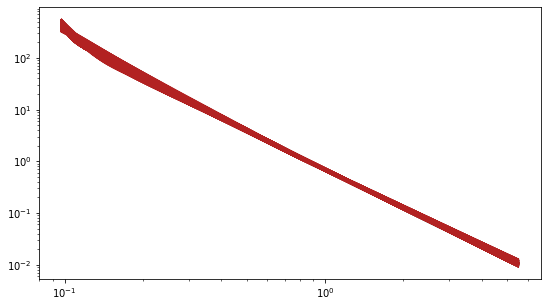

In [94]:
plt.figure(figsize=(10,8))
colors = ['slategray','steelblue','firebrick','#fa5f1b']#,'dimgray','steelblue'
labels = ['All','Blue','Red1','Red2']
rsp_samps_list = []
averaged_r_tot = bin_stack2
r_thr = np.logspace(np.log10(np.min(averaged_r_tot)), np.log10(np.max(averaged_r_tot)), 3000)

plt.figure(figsize=(9,5))
for j in range(len(sampler_list)):
    indices = np.random.choice(sample_list[j].shape[0], 10000, replace=False)
    samp_list = sample_list[j][indices]
    #sampler_list[j]
    r_sp_samps = np.zeros_like(samp_list[:,0])#(sampler_list[j].flatlnprobability)
    count = 0
    count_all = 0
    for i, sample in enumerate(samp_list):
        progress_bar(i, len(samp_list))
        r_spi= get_rsp(r_thr,sample, rho_g_list)
        r_sp_samps[i] = r_spi
        if r_spi <=.3:
            #print('yes')
            plt.plot(r_thr, rho_DK14(sample, r_thr, rho_g_list[j]), color=colors[j], label="Model Fit")
            plt.xscale('log')
            plt.yscale('log')
            #print('rthr values=', (r_thr[:5]))
            count+=1
            #print(sample)
            #print(r_spi)
        count_all += 1
        progress_bar(i+1, len(samp_list))
    #print('count %s = %s, count total = %s' %(j,count, count_all))
    mean = np.mean(r_sp_samps)
    variance = np.var(r_sp_samps)
    sigma = np.std(r_sp_samps)#np.sqrt(variance)
    x = np.linspace(min(r_sp_samps), max(r_sp_samps), 100)
    #res = plt.hist(r_sp_samps, bins=30, alpha=0.3, color = colors[j],label=labels[j])
    #dx = res[1][1] - res[1][0]
    #scale = len(r_sp_samps)*dx
    rsp_samps_list.append(r_sp_samps)
    #plt.figure()
    #plt.plot(x, scipy.stats.norm.pdf(x, mean, sigma)*scale, color='k', linestyle="--")
    #plt.title(r"$R_{sp}$ Posterior ", fontsize=16)
    #plt.legend(frameon=False)
    #plt.xlabel(r"$r$ [h$^{-1}$Mpc]")
    #plt.ylabel("Counts")
plt.show()


4
1.0099013689631753
0 1.1606717948677927 0.008283874096024458
0 1.1606717948677927 0.008283874096024458
1 4.159642926140638 0.009531045336782036
1 nan nan


/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for

2 0.8372928582666401 0.24324292443875556
2 0.9073268462575953 0.09788986705184274
3 1.3157336806133069 0.06815112239838507
3 1.3156134454640394 0.06708558024616385


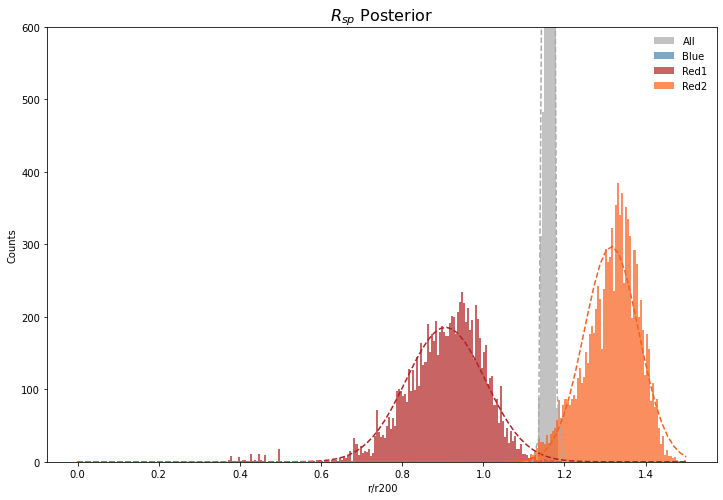

[1.1606717948677927, nan, 0.9073268462575953, 1.3156134454640394] [0.008283874096024458, nan, 0.09788986705184274, 0.06708558024616385]


In [95]:
print(len(rsp_samps_list))
print(np.mean(rsp_samps_list[0]))

colors = ['darkgray','steelblue','firebrick','#fa5f1b']
#labels = ['Red1-low','Red2-low','Red1-high','Red2-high']
alpha_list = [.7,.7,.7,.7]
plt.figure(figsize=(12,8))
means_colors = []
sigs_colors = []
for j in range(len(rsp_samps_list)):#(2,3):#
    r_sp_samps = rsp_samps_list[j]/R_avg2
    print(j,np.mean(r_sp_samps), np.std(r_sp_samps))
    r_sp_samps = r_sp_samps[(r_sp_samps>.3) & (r_sp_samps <2)] #.4
    mean = np.mean(r_sp_samps)
    variance = np.var(r_sp_samps)
    sigma = np.std(r_sp_samps)
    means_colors.append(mean)
    sigs_colors.append(sigma)
    print(j,np.mean(r_sp_samps), np.std(r_sp_samps))

    
    #mu,std = scipy.stats.norm.fit(r_sp_samps)
    x = np.linspace(0,1.5,100)#(min(r_sp_samps), max(r_sp_samps), 100)#
    res = plt.hist(r_sp_samps, bins=300, alpha=alpha_list[j], color = colors[j],label=labels[j], range=[0,1.5])#
    dx = res[1][1] - res[1][0]
    scale = len(r_sp_samps)*dx
    #rsp_samps_list.append(r_sp_samps)
    plt.plot((1)*x, scipy.stats.norm.pdf(x, mean, sigma)*scale, color=colors[j], linestyle="--")
    plt.title(r"$R_{sp}$ Posterior ", fontsize=16)
    plt.legend(frameon=False)
    plt.xlabel('r/r200')#r"$r$ [h$^{-1}$Mpc]")#
    plt.ylabel("Counts")
    plt.ylim(0,600)
    #print(mean,variance,sigma)
    #print(mu,std)
plt.show()
print(means_colors,sigs_colors)


/home/mattbel/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


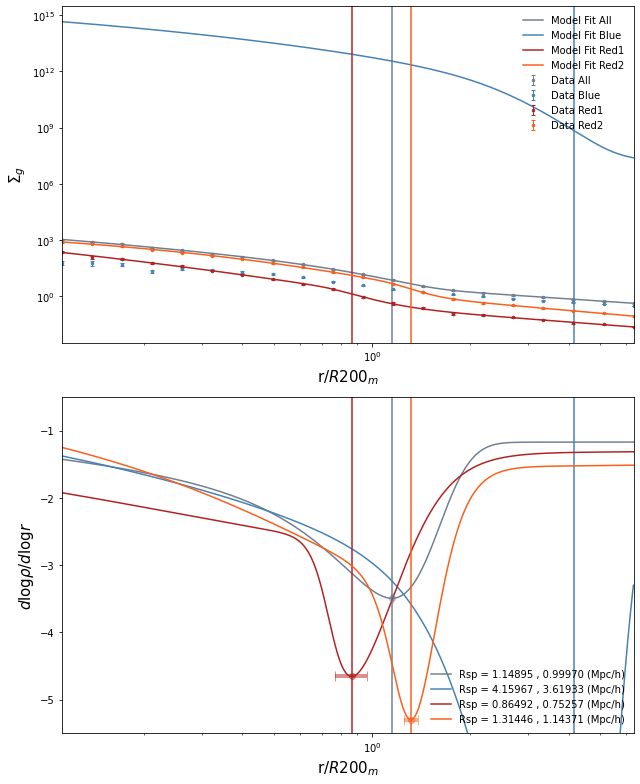

R_avg= 0.8701007239330811
[0.9997001917985239, 3.6193343816306345, 0.7525673395734344, 1.1437138032703529]


In [96]:
# MCMC FITTING COLOR SPLIT PROFILES
colors = ['slategray','steelblue','firebrick','#fa5f1b']#,'dimgray','steelblue'
labels = ['All','Blue','Red1','Red2']
#labels = ['Low stellar mass Red','High stellar mass Red']

ls_list = ['-','-','-','-']

#BASIC
# NOT RUN
profiles = Yi_avg_list2#
covs = cov_list2#[cov_list2[2],cov_list2[3]]
averaged_r_tot = bin_stack2
r_sp_list, r_sp_r200_list = FittedPlots(best_fit_mcmc_list, profiles, averaged_r_tot,R_avg2,covs,rho_g_list,sigs_colors,labels, colors, ls_list)
'''
#REFINED
profiles = [Yi_avgR, Yi_avg_blueR, Yi_avg_redR,Yi_avg_greenR]
covs = [covR, cov_blueR, cov_redR,cov_greenR]
averaged_r_tot = bin_stackR
r_sp_list = FittedPlots(best_fit_mcmc_listR, profiles, averaged_r_tot,covs,rho_g_list,labels, colors, ls_list)
'''

print(r_sp_list)
#print(R_avg1, 2./R_avg1)


